In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy
from scipy.sparse.linalg import svds

In [4]:
data = pd.read_csv("mirnas_all_nov21.txt", sep="\t")
labels = pd.read_csv("mirnas_all_labels_nov21.txt", sep="\t")

data=data.drop(['Unnamed: 0'], axis=1)
data.set_index('ID_REF')
data.head()

,ID_REF,GSM279964,GSM279974,GSM279975,GSM279977,GSM279978,GSM279958,GSM279961,GSM279963,GSM279965,...,GSM237966,GSM237967,GSM237968,GSM237969,GSM237970,GSM237972,GSM237973,GSM237974,GSM237977,GSM237978
0,1007_s_at,10.022909,9.818693,9.647424,9.841938,9.190691,10.214065,10.284017,7.008211,9.145673,...,3739.4300,2809.7200,2350.390,4079.3500,7302.00000,2898.6400,3494.1600,5225.7500,5917.5400,4249.9400
1,1053_at,6.411660,5.665370,5.613482,5.190008,5.180046,6.396298,6.048790,5.671556,5.624627,...,1205.6400,883.9270,1418.130,721.6150,641.33900,1009.4900,788.6240,1227.7000,662.1490,1315.5500
2,117_at,6.181633,5.700626,5.786576,5.237599,6.131352,7.620443,6.481317,5.739559,6.072929,...,89.1387,81.6689,366.327,151.8190,191.91400,134.4140,67.0623,104.0020,15.1112,119.9420
3,121_at,7.436633,7.053211,7.258615,7.562595,7.330315,7.364233,7.421833,7.620457,7.507055,...,787.3290,848.5340,1454.480,1142.3000,1099.31000,762.8810,408.8580,684.3200,612.0700,809.6950
4,1255_g_at,2.887094,3.000947,3.121344,3.086248,3.480671,2.905494,2.968376,3.221801,3.069448,...,80.9794,30.6078,103.337,36.9773,5.61104,92.5094,30.6197,17.8383,11.1367,93.9161


In [5]:
# tiffany's PCA, uses SVD
def PCA(PCA_K, input_data):

    total_dim, sample_n = input_data.shape

    data_mean = np.reshape(np.mean(input_data, axis=1),(total_dim,1))
    data_demean = np.subtract(input_data, data_mean)

    u, s, vt = svds(data_demean, k=PCA_K)

    PCA_weights = np.matmul(np.transpose(u), data_demean)
    
    return PCA_weights, u, s, data_mean


In [6]:
# will need these to recreate data frame later
data_heading=data.columns
id_refs=data['ID_REF']

np_data = np.array(data)[:,1:].astype(float)
np_data.shape

(54675, 1494)

## Dimensionality Reduction (PCA)

In [7]:
num_dims = 500
weights, u, s, mean = PCA(num_dims, np_data)

In [53]:
num_features = 50
pca_data = np.matmul(np.transpose(u[:,num_dims - num_features:]), np.subtract(np_data,mean))

In [54]:
# get labels 
sample_labels=labels['Sample_label'].values

sample_labels = ['Normal' if x=='Metastasis Normal' or x=='Primary Normal' else x for x in labels['Sample_label'].values]
sample_labels=np.asarray(sample_labels)

In [55]:
np.unique(sample_labels,return_counts=True)

(array(['Metastasis Tumor', 'Normal', 'Primary Tumor'], dtype='<U16'),
 array([ 243,   75, 1176]))

## Test Train Split

In [56]:
# train test split 
np.random.seed(69)
ii = np.random.rand(len(pca_data[0])) < 0.7 

# np_data = data.values
# np_types = types.values
# np_labels = labels.values

# # scaling data 
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# np_data_min_max = min_max_scaler.fit_transform(np_data)

train = pca_data[:,ii]
test = pca_data[:,~ii]

train_labels = sample_labels[ii]
test_labels = sample_labels[~ii]

gsms=data.columns[1:]
train_gsm = gsms[ii]
test_gsm=gsms[~ii]
# train = np_data[ii]
# test = np_data[~ii]

# pand_train = data[ii]
# pand_test = data[~ii]

In [57]:
uniqs, counts = np.unique(train_labels, return_counts=True)
print(counts)
print(train.shape)

[168  50 831]
(50, 1049)


## Training Model and Prediction

In [58]:
def compute_confusion_matrix(true, pred):
    '''
    Compute a confusion matrix using numpy for two np.arrays
    true and pred.

    Results are identical (and similar in computation time) to: 
    "from sklearn.metrics import confusion_matrix"

    https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
    '''
    # lol map of indicies for non-numeric classes
    count=0
    idx={}
    for i in np.unique(true):
        idx[i]=count
        count+=1
        
    K = len(np.unique(true)) # Number of classes 
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[idx[true[i]]][idx[pred[i]]] += 1
        
    print("Accuracy: " + str(np.trace(result)/len(true)))

    return result


In [59]:
def pdf_no_loop(X, mu, sigma):
    
    sigma_det = np.linalg.det(np.array(sigma))
    #sigma_det = np.linalg.slogdet(np.array(sigma))
    sigma_inv = np.linalg.inv(np.array(sigma))
    
    #print("Det and Inv", sigma_det, sigma_inv)
    
    denominator = np.sqrt(2 * np.pi * sigma_det)
    no_mean = X - mu
    #print("No mean", no_mean)
    numerator = np.exp(-(1/2) * no_mean.T.dot(sigma_inv.dot(no_mean)))    
    
    #print((numerator/denominator).shape)
    
    print("num and dem", numerator, denominator)
        
    
    return numerator/denominator

In [60]:
def pdf_log(X, mu, sigma):
    #sigma_det = np.linalg.det(np.array(sigma))
    sigma_det = np.sum(np.log(np.diag(sigma)))
    sigma_inv = np.linalg.inv(np.array(sigma))
    eps = 1e-6
    
    denominator = 0.5 * np.log((2 * np.pi * sigma_det) + eps)
    no_mean = X - mu
    numerator = -(1/2) * no_mean.T.dot(sigma_inv.dot(no_mean)) + eps
    
    #print(numerator)
    
    return numerator - denominator

In [61]:
# This function finds the covariance
def covariance(X):
    #print(X.shape)
    N = X.shape[1] - 1
    covariance =  X.dot(X.T) / (N)
    return covariance

In [62]:
#num_features = 88
# find mean and cov for each class
means = []
covs = []

prev = 0
for c in counts:
    mrna = train[:, prev: c]
    print("Size of train class:", mrna.shape)
    
    means.append(np.mean(mrna, axis=1))
    norm = mrna.T - np.mean(mrna, axis=1)
    cov = covariance(norm.T).reshape(num_features * num_features)
    covs.append(cov)

# result should be mean = 88 x 3 array
means = np.array(means).T
print(means.shape)

# result for cov should be num_features * num_features x 10 array that can be reshaped to 2x2
covs = np.array(covs).T

# Now have covariance and means for each class
#return means, covs, pca[0], pca[2]
#return means, covs, pca2.components_, pca2.mean_

Size of train class: (50, 168)
Size of train class: (50, 50)
Size of train class: (50, 831)
(50, 3)


In [63]:
print(means)

[[ 4.54894565e+01  5.59070590e+02 -5.47843689e+01]
 [ 8.28163097e+01 -5.09752112e+02  2.60586377e+02]
 [-5.70102817e+02  1.52797292e+02 -3.41433237e+02]
 [-7.26511138e+02 -5.84363457e+02 -1.39807287e+02]
 [-9.86684743e+02  2.28626376e+02 -2.05464843e+02]
 [-6.31259308e+02 -5.26610053e+02 -4.38141128e+01]
 [-3.66217768e+02  4.88546953e+02 -5.37271135e+00]
 [ 8.44860740e+02  4.67158253e+02  2.55585923e+02]
 [ 4.83503935e+02  1.24236064e+02  1.44344522e+01]
 [-1.72344063e+03  9.36022944e+02 -3.03453486e+02]
 [-9.44928241e+02  1.56638963e+02 -1.13188947e+02]
 [ 5.83096114e+02  5.62518392e+02  2.07624864e+01]
 [ 3.76943913e+02 -2.07371615e+02 -1.64127994e+01]
 [-1.88419536e+03 -1.90639459e+02 -6.75016295e+02]
 [ 1.10802595e+03  4.47566512e+02 -1.89105553e+02]
 [ 5.85831119e+02 -9.93652741e+00 -1.12866829e+02]
 [ 1.34676750e+03  2.09169025e+02  3.79917206e+01]
 [-1.32729263e+03  4.65627707e+02 -5.42278503e+02]
 [ 6.97544730e+02  3.41042022e+02 -3.62534286e+02]
 [ 1.01205444e+03 -7.57775175e+

In [64]:
pdfs = []
count = 0

for digit in test.T:
    pdfs.append([])
    for mu in range(means.shape[1]):
        #print(mus.shape)
        res = pdf_log(digit, means[:, mu], covs[:, mu].reshape((num_features, num_features)))
        pdfs[count].append(res)
    count += 1

In [65]:
max_pdfs = np.argmax(pdfs, axis=1)
preds = []
for i in max_pdfs:
    preds.append(uniqs[i])
    
preds = np.array(preds)
print(preds)

['Primary Tumor' 'Primary Tumor' 'Primary Tumor' 'Primary Tumor'
 'Primary Tumor' 'Primary Tumor' 'Primary Tumor' 'Primary Tumor'
 'Primary Tumor' 'Primary Tumor' 'Primary Tumor' 'Primary Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor'
 'Metastasis Tumor' 'Metastasis Tumor' 'Metastasis Tumor' 'Primary Tumor'
 'Primary Tumor' 'Metastasis Tumor'

In [66]:
y_true = pd.Series(test_labels)
y_pred = pd.Series(preds)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Metastasis Tumor,Primary Tumor,All
True,,,
Metastasis Tumor,17,58,75
Normal,0,25,25
Primary Tumor,55,290,345
All,72,373,445


Accuracy: 0.6898876404494382


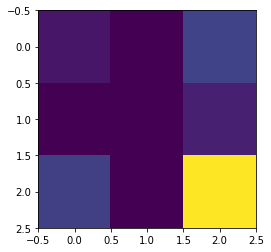

In [67]:
cm = compute_confusion_matrix(test_labels, preds)
plt.imshow(cm)

## Observations

With 150 and 88 features, the accuracy was lower; Maybe this is too many features to accurately tell apart the three types. With a lower amount (50), I was getting a higher accuracy (~70% compared to ~26%) which means the lower amount of features is better at predicting the difference between the three categories.